In [1]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from sklearn.metrics import f1_score, classification_report,confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold



2024-12-15 12:17:32.927122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 12:17:32.944319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734257852.958448  402524 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734257852.962207  402524 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 12:17:32.979570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # Set limit to 8GB

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert grayscale images (28x28x1) to 3 channels (28x28x3)
train_images = tf.repeat(train_images[..., tf.newaxis], 3, axis=-1)
test_images = tf.repeat(test_images[..., tf.newaxis], 3, axis=-1)

# Resize the from original model size of (224, 224, 3) images to a smaller size (64, 64) 
# due to VRAM limitations  
train_images = tf.image.resize(train_images, (64, 64))  
test_images = tf.image.resize(test_images, (64, 64))    

# One-hot encode the labels
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)



I0000 00:00:1734257855.726529  402524 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze the base model


/tmp/ipykernel_402524/3541323419.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


In [4]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Flatten the feature maps
    layers.Dense(256, activation='gelu'),  # Custom dense layer with 256 nodes
    layers.Dropout(0.5),  # Regularization
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
base_model.trainable = True

early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=30,                  # Stop training after 5 epochs without improvement
    verbose=1,                   # Print a message when stopping
    mode='min',                  # Looking for the minimum validation loss
    restore_best_weights=True,   # Restore weights from the best epoch
)


# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=150,
    batch_size=16,
    callbacks=[early_stopping]

)
model.save("/mnt/c/Users/zeiad/Downloads/ML-Project/model.keras")

#approx 35 mins to train

Epoch 1/150


I0000 00:00:1734257873.105176  402808 service.cc:148] XLA service 0x7ff16c002a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734257873.105296  402808 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-15 12:17:53.489581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734257875.429851  402808 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-15 12:18:01.141748: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng53{k2=1,k13=0,k14=3,k18=0,k23=0} for conv (f32[16,384,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,4,4]{3,2,1,0}, f32[384,64,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_resu

   2/3750 ━━━━━━━━━━━━━━━━━━━━ 4:48 77ms/step - accuracy: 0.2031 - loss: 2.8577   

I0000 00:00:1734257891.847574  402808 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.7524 - loss: 0.8025 - val_accuracy: 0.7120 - val_loss: 1.2493
Epoch 2/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8782 - loss: 0.3677 - val_accuracy: 0.3804 - val_loss: 5.9487
Epoch 3/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8939 - loss: 0.3122 - val_accuracy: 0.6319 - val_loss: 1.7802
Epoch 4/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9022 - loss: 0.2940 - val_accuracy: 0.8834 - val_loss: 0.4215
Epoch 5/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.9174 - loss: 0.2426 - val_accuracy: 0.9102 - val_loss: 0.2701
Epoch 6/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9234 - loss: 0.2198 - val_accuracy: 0.9099 - val_loss: 0.2713
Epoch 7/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9315 - loss: 0.2031 - val_accuracy: 0.9075 - val_loss: 0.2938
Epoch 8/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9351 - los

In [6]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Get model predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert to label indices

# Convert true labels to label indices
true_labels = np.argmax(test_labels, axis=1)

# Compute the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"MobileNetV2 Accuracy: {test_accuracy}")
print(f"MobileNetV2 F1 score: {f1:.2f}")

2024-12-15 13:03:36.079093: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 16 bytes spill stores, 16 bytes spill loads

2024-12-15 13:03:36.132353: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181_0', 112 bytes spill stores, 144 bytes spill loads

2024-12-15 13:03:36.382839: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 228 bytes spill stores, 228 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9392 - loss: 0.2011
Test accuracy: 93.77%
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
MobileNetV2 Accuracy: 0.9376999735832214
MobileNetV2 F1 score: 0.94


In [7]:
# Generate predictions on the test set
predictions = model.predict(test_images)

# Convert predicted probabilities to class indices
pred_y = np.argmax(predictions, axis=1)

# Convert one-hot encoded test labels to class indices
true_y = np.argmax(test_labels, axis=1)

# Print the classification report
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
print(classification_report(true_y, pred_y, target_names=label_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.90      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.94      0.90      0.92      1000
       Dress       0.91      0.96      0.93      1000
        Coat       0.90      0.92      0.91      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.82      0.80      0.81      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle Boot       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


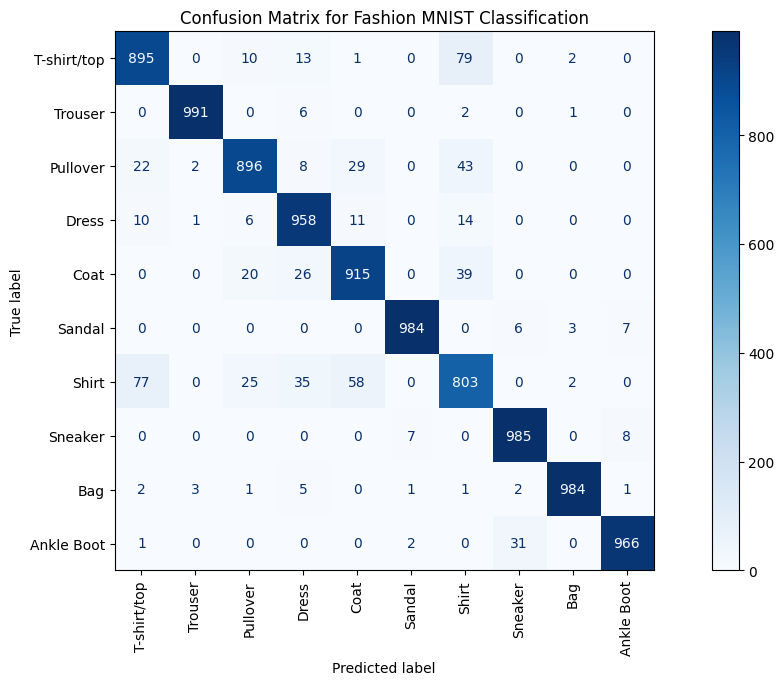

In [8]:
# Label names for Fashion MNIST
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Assume `model` is your trained model
# Generate predictions on the test dataset
predictions = model.predict(test_images, batch_size=16)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.xticks(rotation=90)
plt.title("Confusion Matrix for Fashion MNIST Classification")
plt.show()

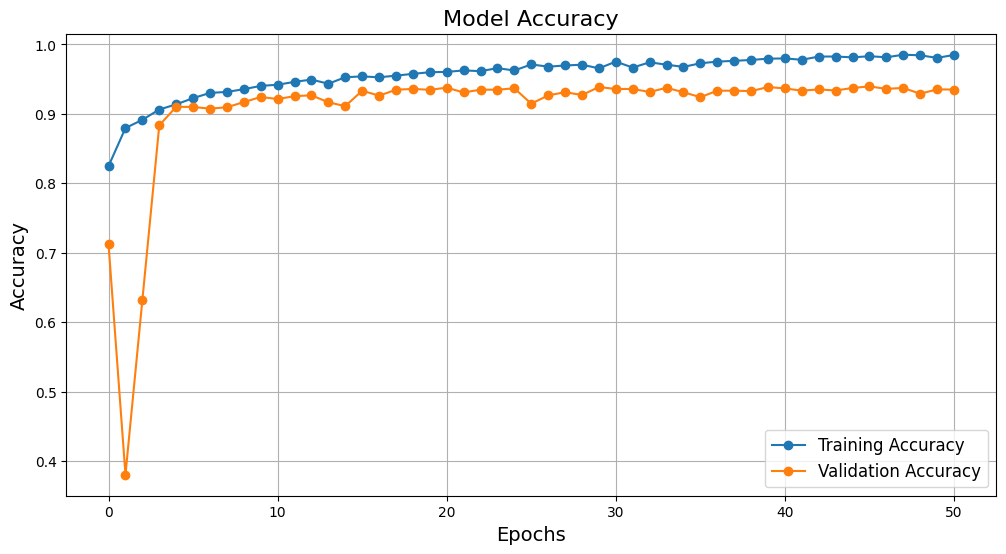

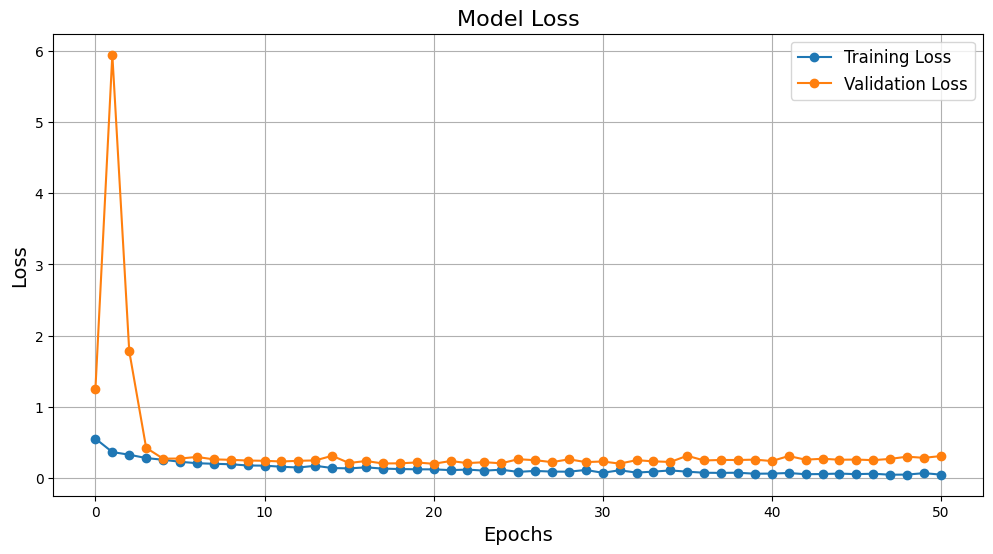

In [9]:
# Plot training history
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title('Model Accuracy', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title('Model Loss', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()
plot_history([history_finetune], ["MobileNetV2"])